# Short term trading strategies that work

In this notebook, strategies mentioned in the book 'Short term trading strategies that work' from Larry Connors are investigated. This book mainly focuses on short-term mean-reversion strategies in the US equity market.

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.style.use('bmh')
import pandas as pd

from vivace.backtest import (BacktestEngine, Strategy, Weighting, InstrumentDef,
                             Performance, signal, processing, rebase, PnLType)
from vivace.backtest.engine import long_only_returns

# Strategy 1
If the following conditions are met, go long the equity market for 5 days.
- It went down 3 days in a row
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [2]:
instruments = ['SPY', 'QQQ', '^GDAXI', '^N225']

In [3]:
def run_strat_1(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.ConsecutiveSign(n_consecutive=3, lookback_direction=-1, position=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine


def run_backtests(backtest_func, instruments):
    result = []

    for name in instruments:
        instrument = InstrumentDef(name, pnl_type=PnLType.ADJCLOSE_TO_ADJCLOSE.value)
        strat_engine = backtest_func(instrument)
        strat_equity_curve = strat_engine.calculate_equity_curve(calculate_net=False).rename(f'Strategy 1 ({name})')
        long_only = long_only_returns(instrument, strat_equity_curve.index[0], strat_equity_curve.index[-1])
        long_only_equity_curve = long_only.add(1).cumprod().rename(f'Long-only ({name})')

        result.append(
            pd.concat((long_only_equity_curve, strat_equity_curve), axis=1).pipe(rebase)
        )
    return result

In [4]:
strategy_1_result = run_backtests(run_strat_1, instruments)

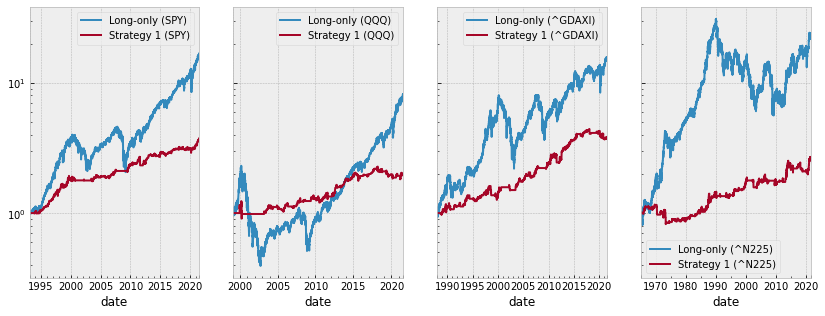

In [5]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.plot(ax=ax, logy=True)

In [6]:
pd.concat([i.pipe(Performance).summary() for i in strategy_1_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112417,0.047225,0.127427,0.034228,0.102305,0.041193,0.071876,0.018406
CAGR,0.095340,0.044838,0.090285,0.029782,0.078231,0.037966,0.052640,0.016079
Annualised vol,0.184735,0.068971,0.272823,0.094557,0.219251,0.080035,0.195925,0.067768
Sharpe ratio,0.608533,0.684703,0.467070,0.361985,0.466611,0.514684,0.366857,0.271599
Max drawdown,0.551894,0.140756,0.829639,0.265982,0.726848,0.217462,0.818712,0.292850
Calmar ratio,0.203694,0.335507,0.153594,0.128686,0.140751,0.189426,0.087792,0.062850
Skewness,-0.050648,-1.128278,0.239532,1.685613,-0.130771,-1.970881,-0.198937,-4.077790
Kurtosis,12.650615,47.378366,7.521824,88.193293,6.829421,75.967326,9.721397,166.339205
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.131434,-0.149009,-0.149009


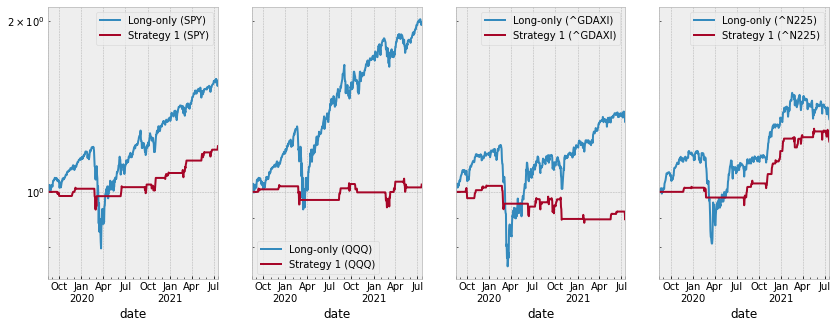

In [7]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_1_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 2

If the following conditions are met, go long the equity market for 5 days.
- It the market made new 10-day lows
- Price is above 200 day MA. Rationale is to go long when long-term trend is up and capture temporal pullback.

In [8]:
def run_strat_2(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.LocalMinimum(lookback=10, shift=1)
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [9]:
strategy_2_result = run_backtests(run_strat_2, instruments)

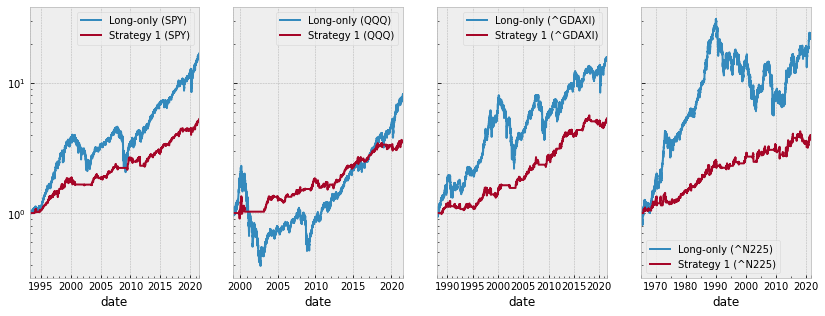

In [10]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.plot(ax=ax, logy=True)

In [11]:
pd.concat([i.pipe(Performance).summary() for i in strategy_2_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112417,0.059651,0.127427,0.061093,0.102305,0.051893,0.071876,0.026600
CAGR,0.095340,0.056408,0.090285,0.054497,0.078231,0.047988,0.052640,0.022943
Annualised vol,0.184735,0.080430,0.272823,0.115008,0.219251,0.088365,0.195925,0.085088
Sharpe ratio,0.608533,0.741647,0.467070,0.531210,0.466611,0.587259,0.366857,0.312619
Max drawdown,0.551894,0.160132,0.829639,0.265982,0.726848,0.201483,0.818712,0.251076
Calmar ratio,0.203694,0.372509,0.153594,0.229689,0.140751,0.257554,0.087792,0.105944
Skewness,-0.050648,-0.777227,0.239532,0.702667,-0.130771,-0.074626,-0.198937,-2.530306
Kurtosis,12.650615,30.224074,7.521824,47.968479,6.829421,16.427767,9.721397,86.575556
Worst return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.086647,-0.131434,-0.058299,-0.149009,-0.149009


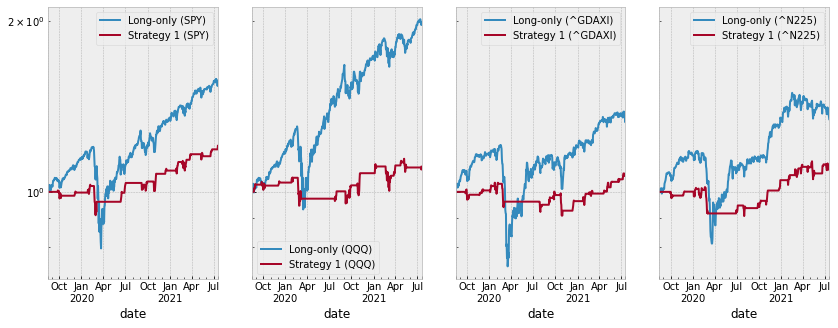

In [12]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_2_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 3

This strategy is the so-called "Double 7's strategy".

In [13]:
def run_strat_3(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Double7Connors(),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [14]:
strategy_3_result = run_backtests(run_strat_3, instruments)

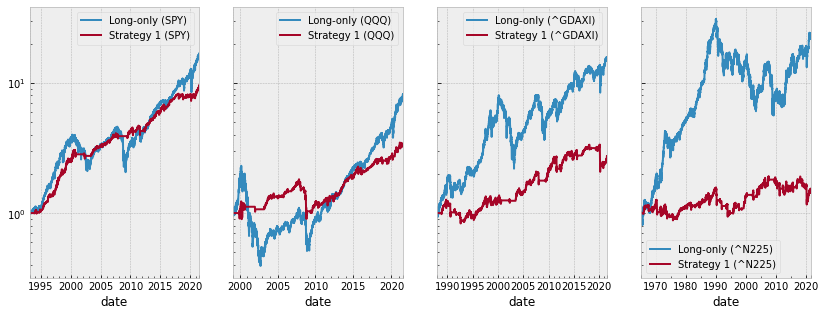

In [15]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.plot(ax=ax, logy=True)

In [16]:
pd.concat([i.pipe(Performance).summary() for i in strategy_3_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112417,0.081398,0.127427,0.063120,0.102305,0.035747,0.071876,0.012687
CAGR,0.095340,0.076706,0.090285,0.052829,0.078231,0.028948,0.052640,0.007318
Annualised vol,0.184735,0.096812,0.272823,0.143679,0.219251,0.116201,0.195925,0.103201
Sharpe ratio,0.608533,0.840786,0.467070,0.439310,0.466611,0.307634,0.366857,0.122935
Max drawdown,0.551894,0.153225,0.829639,0.503464,0.726848,0.382193,0.818712,0.404694
Calmar ratio,0.203694,0.531233,0.153594,0.125371,0.140751,0.093532,0.087792,0.031350
Skewness,-0.050648,-0.310633,0.239532,0.675234,-0.130771,-1.253324,-0.198937,-1.639458
Kurtosis,12.650615,19.069452,7.521824,33.961063,6.829421,39.469776,9.721397,49.211923
Worst return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.089557,-0.131434,-0.131434,-0.149009,-0.149009


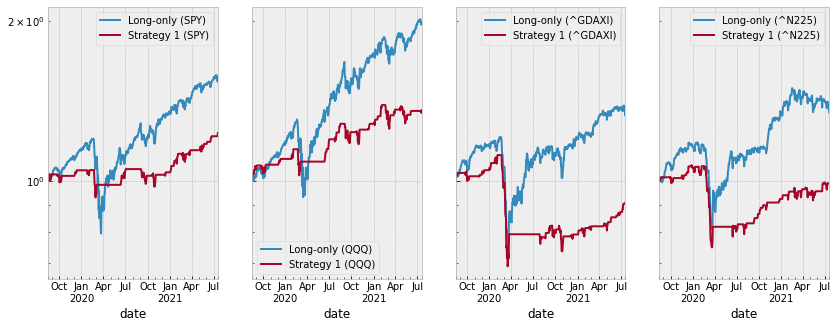

In [17]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_3_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Strategy 4
Month-end strategy which goes long when the following conditions are met:
- n days before month-end
    - (optional) only do so when the previous day is down
- The price is above 200 day MA

In [18]:
def run_strat_4(instrument):
    engine = BacktestEngine(
        strategy=Strategy.DELTA_ONE.value,
        instrument=instrument,
        signal=signal.Pipeline([
            signal.ParallelSignal([
                signal.GreaterThanMA(lookback=200, shift=1),
                signal.MonthEndLong(n_before=5, n_after=0, is_prev_neg=True),
            ], weighting='product', post_process=processing.CarryOver(5))
        ]),
        log_level=logging.WARNING,
    )
    engine.run()
    return engine

In [19]:
strategy_4_result = run_backtests(run_strat_4, instruments)

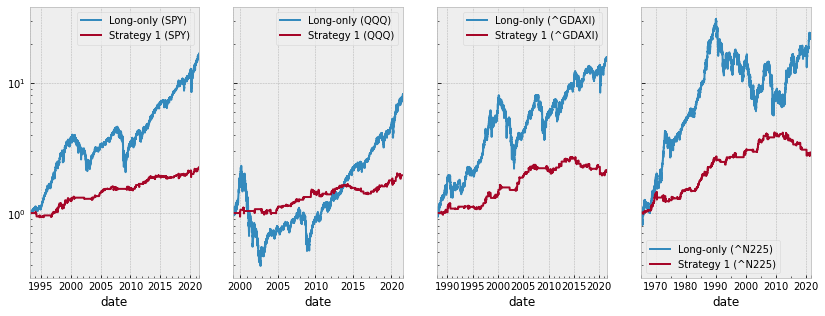

In [20]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.plot(ax=ax, logy=True)

In [21]:
pd.concat([i.pipe(Performance).summary() for i in strategy_4_result], axis=1)

,Long-only (SPY),Strategy 1 (SPY),Long-only (QQQ),Strategy 1 (QQQ),Long-only (^GDAXI),Strategy 1 (^GDAXI),Long-only (^N225),Strategy 1 (^N225)
Annualised return,0.112417,0.029399,0.127427,0.031759,0.102305,0.023614,0.071876,0.019412
CAGR,0.095340,0.027605,0.090285,0.028836,0.078231,0.021612,0.052640,0.018042
Annualised vol,0.184735,0.059840,0.272823,0.076402,0.219251,0.063246,0.195925,0.052206
Sharpe ratio,0.608533,0.491296,0.467070,0.415686,0.466611,0.373360,0.366857,0.371836
Max drawdown,0.551894,0.111611,0.829639,0.166739,0.726848,0.280084,0.818712,0.341473
Calmar ratio,0.203694,0.263409,0.153594,0.190474,0.140751,0.084309,0.087792,0.056848
Skewness,-0.050648,-0.851671,0.239532,-0.509919,-0.130771,-0.283121,-0.198937,-2.443827
Kurtosis,12.650615,54.153185,7.521824,32.942183,6.829421,29.267987,9.721397,105.437191
Worst return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856
Worst 1d return,-0.109424,-0.072474,-0.119788,-0.054422,-0.131434,-0.048098,-0.149009,-0.086856


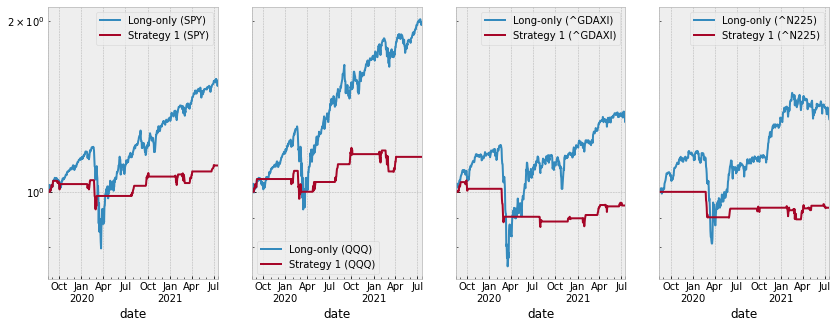

In [22]:
fig, axes = plt.subplots(1, len(instruments), figsize=(14, 5), sharey=True)

for ax, result in zip(axes, strategy_4_result):
    result.tail(252 * 2).pipe(rebase).plot(ax=ax, logy=True)

# Reference
- Connors, L.A. and Alvarez, C., 2009. Short Term Trading Strategies that Work: A Quantified Guide to Trading Stocks and ETFs. TradingMarkets Publishing Group.

In [23]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 21-Jul-2021 07:10
